In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Python Worksheet

Intro blurb

## Setup

### Import packages

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Download OASIS Dataset

We'll be downloading the data from `http://www.oasis-brains.org/pdf/oasis_longitudinal.csv`.

A full explanation of the data can be found in:

*Open Access Series of Imaging Studies (OASIS): Longitudinal MRI Data in Nondemented and Demented Older Adults. Marcus, DS, Fotenos, AF, Csernansky, JG, Morris, JC, Buckner, RL, 2010. Journal of Cognitive Neuroscience, 22, 2677-2684. doi: 10.1162/jocn.2009.21407*

In [ ]:
df = pd.read_csv('http://www.oasis-brains.org/pdf/oasis_longitudinal.csv')
df

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,OAS2_0185,OAS2_0185_MR2,Demented,2,842,M,R,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,OAS2_0185,OAS2_0185_MR3,Demented,3,2297,M,R,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,OAS2_0186,OAS2_0186_MR1,Nondemented,1,0,F,R,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,OAS2_0186,OAS2_0186_MR2,Nondemented,2,763,F,R,63,13,2.0,30.0,0.0,1327,0.796,1.323


## Pre-processing the Data

### Dementia Status from CDR

In [ ]:
cdr_mapper = {
    0: "No Dementia",
    0.5: "Very Mild Dementia",
    1: "Mild Dementia",
    2: "Moderate Dementia",
    3: "Severe Dementia",
}
df["Status"] = df["CDR"].map(cdr_mapper)

In [ ]:
# Create colours for the different 'Status' categories
status_colours = {
    i:j for i,j in zip(cdr_mapper.values(), sns.color_palette("colorblind", 5))
}

In [ ]:
df["Status"].value_counts()

No Dementia           206
Very Mild Dementia    123
Mild Dementia          41
Moderate Dementia       3
Name: Status, dtype: int64

In [ ]:
# Stretch: get a breakdown of the status by visit? (TO DECIDE)

### Variable Types

In [ ]:
df.dtypes

Subject ID     object
MRI ID         object
Group          object
Visit           int64
MR Delay        int64
M/F            object
Hand           object
Age             int64
EDUC            int64
SES           float64
MMSE          float64
CDR           float64
eTIV            int64
nWBV          float64
ASF           float64
Status         object
dtype: object

**Coerce types? Not actually needed but good practice?**

### Convert Categorical Data

In [ ]:
df["Sex"] = df["M/F"].map({
  "M": 0,
  "F": 1
})

### Visits

In [ ]:
df["Visit"].value_counts()

1    150
2    144
3     58
4     15
5      6
Name: Visit, dtype: int64

Filter for baseline data, and look at their status on arrival

In [ ]:
df_baseline = df.loc[df["Visit"]==1]

In [ ]:
df_baseline["Status"].value_counts()

No Dementia           85
Very Mild Dementia    52
Mild Dementia         13
Name: Status, dtype: int64

## Data Exploration & Analysis

### Summarize Data

In [ ]:
df.describe(include="all")

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Status,Sex
count,373,373,373,373.000000,373.000000,373,373,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000,373.000000,373,373.000000
unique,150,373,3,NaN,NaN,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
top,OAS2_0073,OAS2_0126_MR3,Nondemented,NaN,NaN,F,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Dementia,NaN
freq,5,1,190,NaN,NaN,213,373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206,NaN
mean,NaN,NaN,NaN,1.882038,595.104558,NaN,NaN,77.013405,14.597855,2.460452,27.342318,0.290885,1488.128686,0.729568,1.195461,NaN,0.571046
std,NaN,NaN,NaN,0.922843,635.485118,NaN,NaN,7.640957,2.876339,1.134005,3.683244,0.374557,176.139286,0.037135,0.138092,NaN,0.495592
min,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000,NaN,0.000000
25%,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000,NaN,0.000000
50%,NaN,NaN,NaN,2.000000,552.000000,NaN,NaN,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000,NaN,1.000000
75%,NaN,NaN,NaN,2.000000,873.000000,NaN,NaN,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000,NaN,1.000000


### Missing Data

In [ ]:
# Count amount of missing data
df.isna().sum(0)

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
Status         0
Sex            0
dtype: int64

### Visualize Data

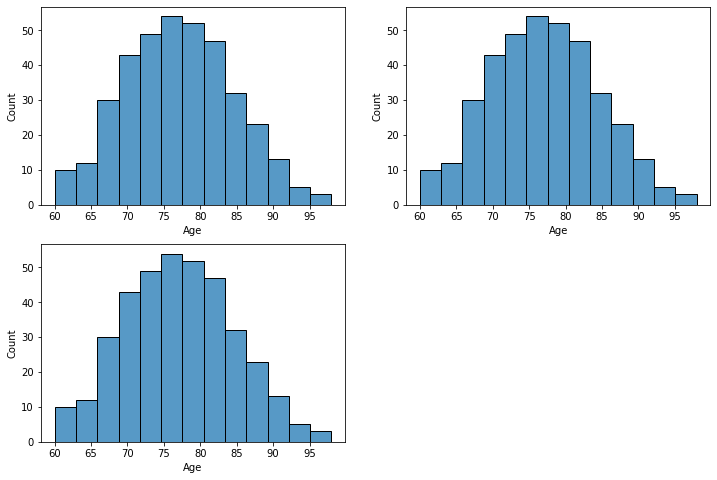

In [ ]:
# Histograms
fig, axes = plt.subplots(2, 2, figsize=(12,8))

axes = axes.flatten()

for i, x_col in enumerate(["Age", "EDUC", "MMSE"]):
  sns.histplot(data=df, x="Age", ax=axes[i])

fig.delaxes(axes[-1])

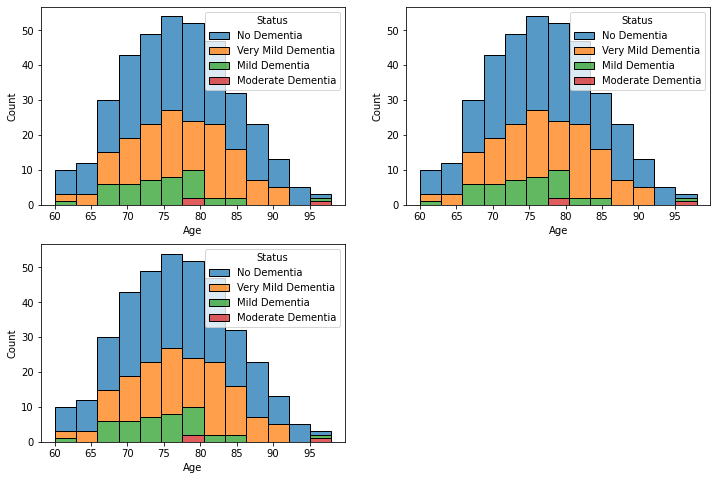

In [ ]:
# Stretch: stratified histograms
fig, axes = plt.subplots(2, 2, figsize=(12,8))

axes = axes.flatten()

for i, x_col in enumerate(["Age", "EDUC", "MMSE"]):
  sns.histplot(data=df, x="Age", hue="Status", multiple="stack", ax=axes[i])
  
fig.delaxes(axes[-1])

## MMSE trajectories over time

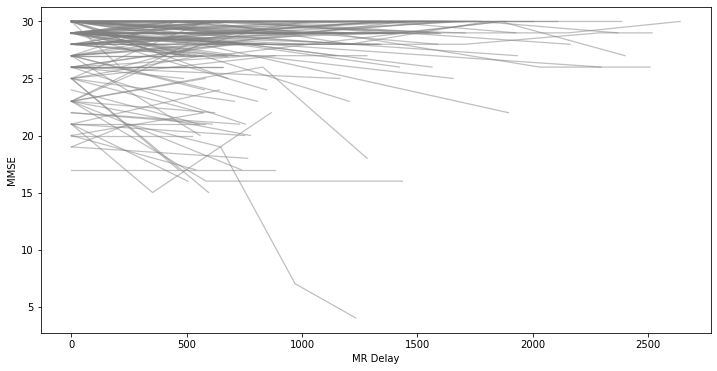

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
for _, indiv_data in df.groupby("Subject ID"):
    ax = sns.lineplot(
        data=indiv_data,
        x="MR Delay",
        y="MMSE",
        ax=ax,
        color="grey",
        alpha=0.5,
        linewidth=1.25,
        linestyle="solid"
    )

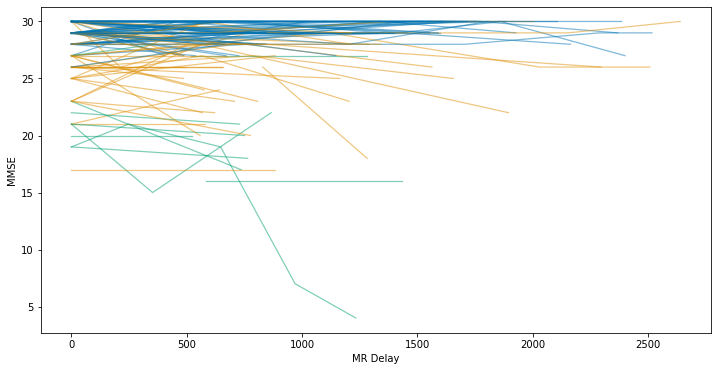

In [ ]:
# Stretch: straified
fig, ax = plt.subplots(figsize=(12,6))

for group, indiv_data in df.groupby(["Subject ID"]):
    ax = sns.lineplot(
        data=indiv_data,
        x="MR Delay",
        y="MMSE",
        ax=ax,
        hue="Status",
        palette=status_colours,
        alpha=0.5,
        linewidth=1.25,
        linestyle="solid",
        legend=False
    )

**Investigate and fix the above, there is a discrepancy**

## Regression Analysis

### Simple Linear Regression

Age vs MMSE: R-squared = 0.001
Sex vs MMSE: R-squared = 0.048
Yrs of Education vs MMSE: R-squared = 0.047
CDR vs MMSE: R-squared = 0.479


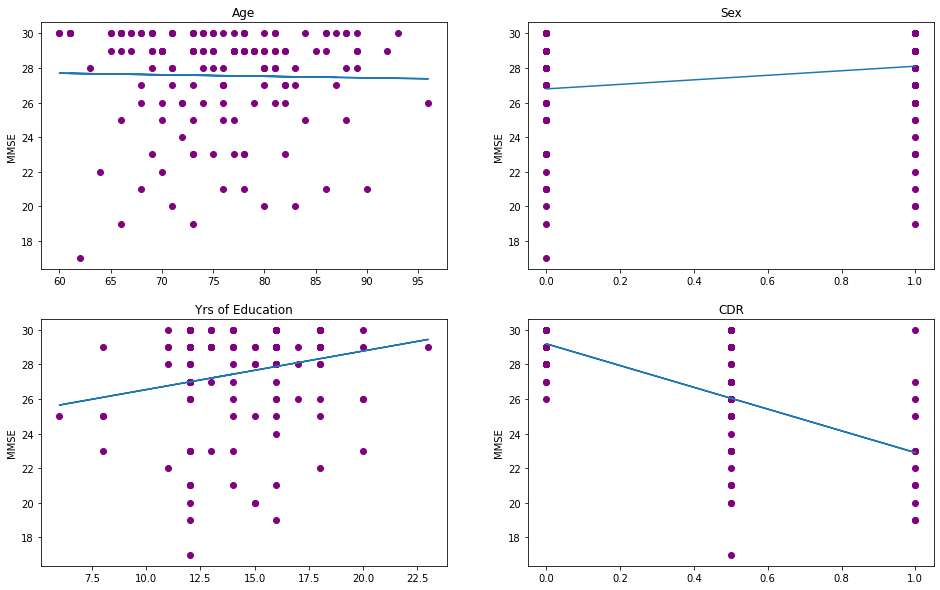

In [ ]:
x_cols = ["Age", "Sex", "EDUC", "CDR"]
x_labels = ["Age", "Sex", "Yrs of Education", "CDR"]

fig, axes = plt.subplots(2,2, figsize=(16,10))

y = df_baseline["MMSE"].values

for x_col, label, ax in zip(x_cols, x_labels, axes.flatten()):
    x = df_baseline[x_col].values
    model = sm.OLS(
        y, sm.add_constant(x)
    )
    res = model.fit()
    
    ax.plot(x, res.predict())
    ax.scatter(x, y, c="Purple")
    ax.set_title(label)
    ax.set_ylabel("MMSE")

    print(f"{label} vs MMSE: R-squared = {res.rsquared:.3f}")

Age vs MMSE: R-squared = 0.001
Sex vs MMSE: R-squared = 0.048
Yrs of Education vs MMSE: R-squared = 0.047
CDR vs MMSE: R-squared = 0.479


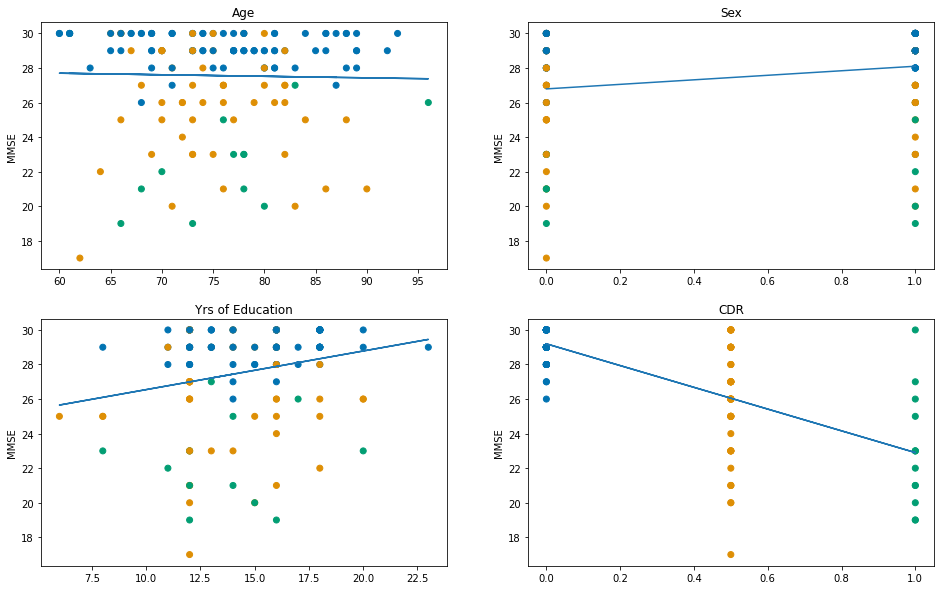

In [ ]:
x_cols = ["Age", "Sex", "EDUC", "CDR"]
x_labels = ["Age", "Sex", "Yrs of Education", "CDR"]

fig, axes = plt.subplots(2,2, figsize=(16,10))

y = df_baseline["MMSE"].values

for x_col, label, ax in zip(x_cols, x_labels, axes.flatten()):
    x = df_baseline[x_col].values
    model = sm.OLS(
        y, sm.add_constant(x)
    )
    res = model.fit()
    
    ax.plot(x, res.predict())
    ax.scatter(x, y, c=[status_colours[i] for i in df_baseline["Status"]])
    ax.set_title(label)
    ax.set_ylabel("MMSE")

    print(f"{label} vs MMSE: R-squared = {res.rsquared:.3f}")

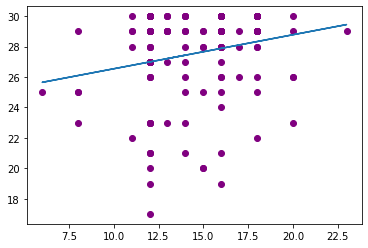

In [ ]:
# Potentially useful function to give them?
def plot_regression(x_var, y_var="MMSE", x_label=None, y_label=None, ax=None):
  x = df_baseline[x_var].values
  y = df_baseline[y_var].values

  model = sm.OLS(
      y, sm.add_constant(x)
  )
  res = model.fit()

  if ax is None:
    fig, ax = plt.subplots()

  ax.plot(x, res.predict())
  ax.scatter(x, y, c="Purple")
  return res

_ = plot_regression("EDUC", x_label="Education")

### Multiple Linear Regression

**We definitely need to give them a lot of this code...perhaps they have to fill in `x`, but we tell them to do `C(CDR)`?**

In [ ]:
x = "Age + EDUC + Sex + C(CDR)"
y = "MMSE"

mod = smf.ols(formula = f"{y} ~ {x}", data=df_baseline)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   MMSE   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     27.95
Date:                Mon, 05 Jul 2021   Prob (F-statistic):           1.02e-19
Time:                        13:30:15   Log-Likelihood:                -324.67
No. Observations:                 150   AIC:                             661.3
Df Residuals:                     144   BIC:                             679.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        29.1743      2.140     13.632

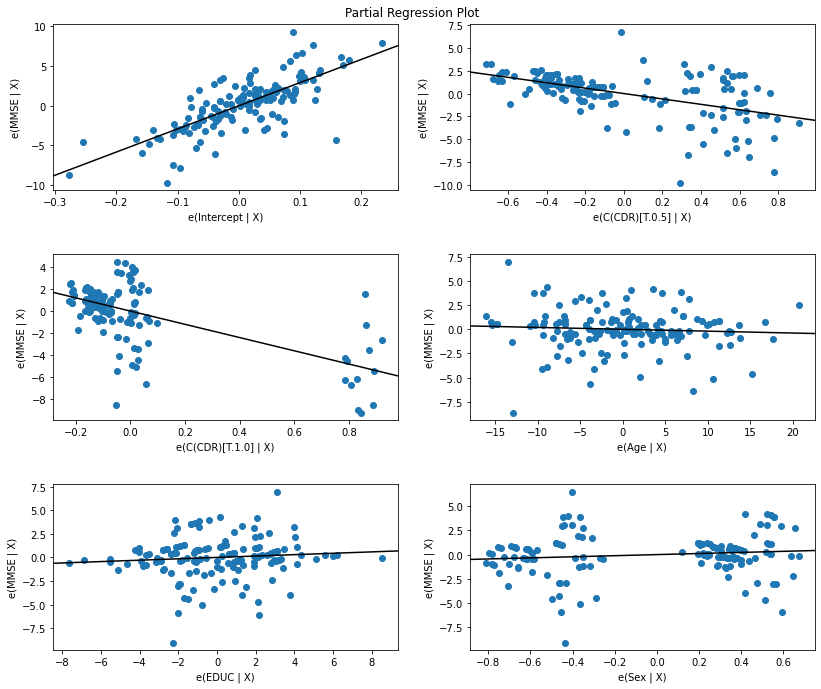

In [ ]:
fig = sm.graphics.plot_partregress_grid(res)
fig.set_figheight(10)
fig.set_figwidth(12)
fig.tight_layout(pad=3)

# TODO

* Finalize: 
  * The actual questions being asked
    * Discrepancy in linear regression - fit for separate groups or just colourize for different groups?
  * Code to be provided, and what is to be filled in/done by them
    * Then can add comments where needed
* PDF export (double-check when all finalized)
* Compile a student and example version?